# Predicting Wikipedia page views

In this notebook, I go through all the steps to predict page views, using fbprophet, and then creating a submission file for Kaggle (which proves to be non-trivial, given the funky submission format), for a single wikipedia page. 

My plan is to then implement this for all of the pages in the wikipedia file. 

1. Initial exploration, and dealing with null values
2. Predictions with fbprophet
3. Generating a submission file

In [1]:
% matplotlib inline

import numpy as np 
import pandas as pd
from fbprophet import Prophet

from matplotlib import pyplot as plt
import seaborn as sns

import itertools

Loading the data

In [2]:
data = pd.read_csv('train_1.csv')

In [154]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


Okay! So we have a wikipedia page, including 

1. the type of wikipedia project (wikipedia.org, for instance) 
2. Type of access ( all, desktop...)
3. The type of agent (eg. spider) 

So that the format is 'name_project_access_agent'. These first few pages are all the Chinese wikipedia pages (hence zh.wikipedia.org). 

In [155]:
len(data)

145063

Let's quickly begin by taking a single page, and looking at how it behaves across time. 

# 1. Initial Exploration 

In [156]:
test_row = data.iloc[50000]

In [157]:
test_row.head()

Page          Suicide_Squad_(Film)_de.wikipedia.org_all-acce...
2015-07-01                                                  NaN
2015-07-02                                                  NaN
2015-07-03                                                  NaN
2015-07-04                                                  NaN
Name: 50000, dtype: object

There are plenty of null values here, but this does make sense; Suicide Squad was only released in August 2016, and a quick peak at the German Wikipedia page for the movie (note de.wikipedia) shows that the page was moved to its current location on the 16th September 2015. Therefore, if I check the page views on the 15th September: 

In [29]:
test_row['2015-09-15']

nan

But, if I check the 16th: 

In [28]:
test_row['2015-09-16']

25.0

So this does suggest that Nan here means the page was not up yet. 

There are quite a number of null cells in the entire data set:

In [32]:
print (data.isnull().sum().sum())

6192931


Considering there are $145063 \times 550 $ cells in the entire dataset, then the ratio of null cells is 

\begin{equation}
\textrm{Ratio} = \frac{6192931}{145063 \times 550} = 0.078
\end{equation}

So about 8% of the cells are empty. However, if - like for Suicide Squad - this is because they were not yet *on* Wikipedia, filling these values with 0 is a reasonable substitute for now. 

In [14]:
data = data.fillna(value = 0)

Now, I can get my same Suicide Squad row: 

In [15]:
test_row = data.iloc[50000]

And see its behavior over the last year: 

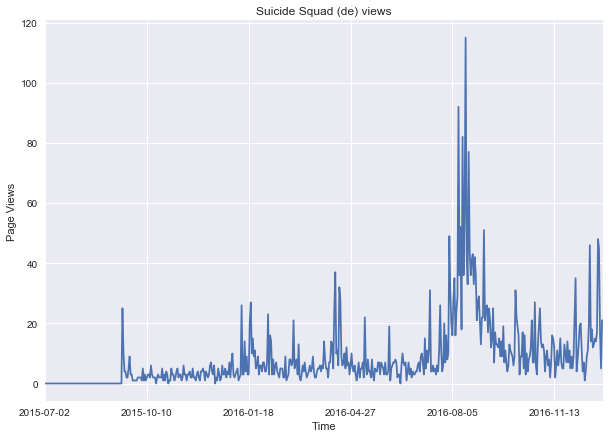

In [143]:
plt.clf()
fig = plt.figure(figsize = (10,7))
plt.title("Suicide Squad (de) views")
plt.xlabel("Time")
plt.ylabel("Page Views")
fig = test_row[1:].plot()
plt.show()

Cool! So there's no activity before the page exists, and a massive spike in August 2016, when the movie is released. 

# 2. Predicting using fbProphet

Just to test fbprophet, lets try predicting the upcoming page views for this movie. fbprophet requires a specific input format for its dataframes, with times in a 'ds' row and views in a 'dy' row. Let's write a quick method which takes a row in the data frame, and returns a dataframe in this format. 

I'll start by defining a dataframe of dates, to which I can add the page views. 

In [16]:
df = pd.DataFrame()
df['ds'] = data.columns[1:]

In [17]:
def preprocess(series, ds):
    '''Takes as input a series in the format of the Kaggle wikipedia competiton
        And returns it in the appropriate format for fbprophet. 
    '''
    ds['y'] = np.array(series)
    return ds

In [23]:
suicide_squad_dataframe = preprocess(test_row[1:], df)
suicide_squad_dataframe.head()

,ds,y
0,2015-07-01,0
1,2015-07-02,0
2,2015-07-03,0
3,2015-07-04,0
4,2015-07-05,0


Now that the dataframe is in the proper format, I can use fbprophet to predict how page views will evolve:

In [24]:
m = Prophet()
m.fit(suicide_squad_dataframe)

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [25]:
future_dates = m.make_future_dataframe(periods = 60) #predicting 2 months into the future

In [26]:
future_dates.tail()

,ds
605,2017-02-25
606,2017-02-26
607,2017-02-27
608,2017-02-28
609,2017-03-01


So now, we have a 'future' dataframe which extends 2 months into the 'future', until March 1st 2017. 

In [27]:
future_suicide_squad_views = m.predict(future_dates)

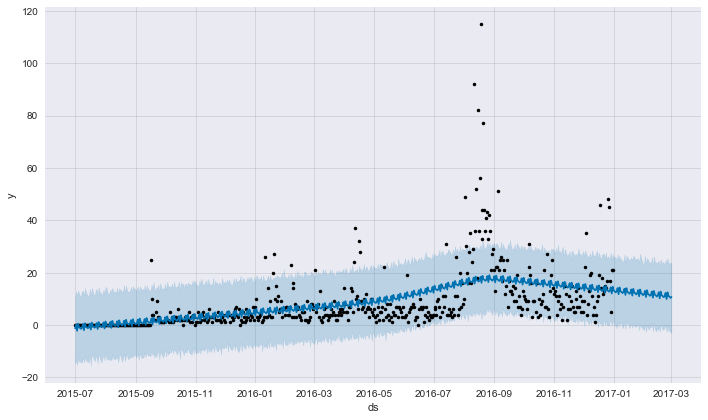

In [147]:
fig = plt.figure(figsize = (7,10))
m.plot(future_suicide_squad_views)
plt.show()

On top of this general forecast, I can plot the components of the forecast: 

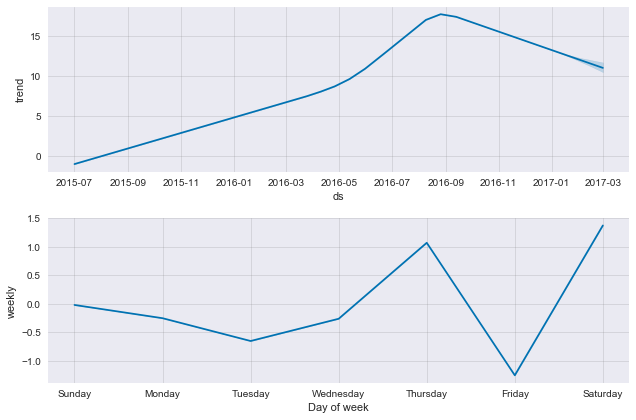

In [148]:
fig = plt.figure(figsize = (7,10))
m.plot_components(future_suicide_squad_views)
plt.show()

# 3. Generating a submission file

In [3]:
keys = pd.read_csv('key_1.csv')

In [173]:
keys.head()

,Page,Id
0,!vote_en.wikipedia.org_all-access_all-agents_2...,bf4edcf969af
1,!vote_en.wikipedia.org_all-access_all-agents_2...,929ed2bf52b9
2,!vote_en.wikipedia.org_all-access_all-agents_2...,ff29d0f51d5c
3,!vote_en.wikipedia.org_all-access_all-agents_2...,e98873359be6
4,!vote_en.wikipedia.org_all-access_all-agents_2...,fa012434263a


In [166]:
keys.iloc[0].Page

'!vote_en.wikipedia.org_all-access_all-agents_2017-01-01'

Okay so on top of making the data, submitting it is not trivial. I'll have the page of the wikipedia article (in the fancy format) and the data. I then need to put this into a dictionary of the keys, so that for every day, I have a new Id:

Now, I want a dictionary from the keys csv which can turn the Page column into an Id:

In [4]:
keys_dict = pd.Series(keys.Id.values, index= keys.Page.values).to_dict()

Let's take a quick look at this result

In [5]:
def glance(d):
    return dict(itertools.islice(d.iteritems(), 3))

glance(keys_dict)

{'BMW_E46_de.wikipedia.org_all-access_spider_2017-01-29': '3e5ce3faba54',
 '\xe5\xae\xb6\xe5\x92\x8c\xe8\x90\xac\xe4\xba\x8b\xe8\x88\x88_(2010\xe5\xb9\xb4\xe9\x9b\xbb\xe8\xa6\x96\xe5\x8a\x87)_zh.wikipedia.org_all-access_all-agents_2017-01-28': 'f0e16b1158b5',
 '\xe5\xae\xb6\xe5\x92\x8c\xe8\x90\xac\xe4\xba\x8b\xe8\x88\x88_(2010\xe5\xb9\xb4\xe9\x9b\xbb\xe8\xa6\x96\xe5\x8a\x87)_zh.wikipedia.org_all-access_all-agents_2017-01-29': 'd39d052e84aa'}

The fancy \xae situtation going on there is just the mandarin characters from zh.wikipedia.org:

In [6]:
keys_dict['龙生九子_zh.wikipedia.org_mobile-web_all-agents_2017-01-31']

'1fb8f902ad0f'

Okay! Given this dictionary, I can take the output of a fbprophet prediction, and use it to make a submission dataframe:

### Creating a "submission file" for Suicide Squad

So the entries to the dictionaries consist of the Page information, and a date. I am going to define a prefix which will allow me to do this: 

In [28]:
prefix = test_row.Page

In [29]:
future_suicide_squad_views.head()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,seasonal,yhat
0,2015-07-01,0.000000,-0.995636,-0.261908,-0.261908,-0.995636,-0.995636,-14.319565,12.164152,-0.261908,-0.261908,-0.261908,-0.261908,-1.257544
1,2015-07-02,0.001821,-0.964131,1.066858,1.066858,-0.964131,-0.964131,-12.348112,13.419145,1.066858,1.066858,1.066858,1.066858,0.102727
2,2015-07-03,0.003643,-0.932626,-1.250915,-1.250915,-0.932626,-0.932626,-14.796996,11.877081,-1.250915,-1.250915,-1.250915,-1.250915,-2.183541
3,2015-07-04,0.005464,-0.901120,1.369789,1.369789,-0.901120,-0.901120,-11.555805,12.153890,1.369789,1.369789,1.369789,1.369789,0.468669
4,2015-07-05,0.007286,-0.869615,-0.020627,-0.020627,-0.869615,-0.869615,-13.848017,12.353340,-0.020627,-0.020627,-0.020627,-0.020627,-0.890242


The variable I am going to be using as my predictions is y_hat. Unfortunately, some of the values are negative, which does't make sense. I am therefore going to clip this column, so that values cannot be smaller than 0. 

In [38]:
yhat = future_suicide_squad_views.yhat
yhat = yhat.clip(lower = 0)
yhat.head()

0    0.000000
1    0.102727
2    0.000000
3    0.468669
4    0.000000
Name: yhat, dtype: float64

Perfect. Now, given a value ds, I can turn this into a Page, which I can then turn into an Id using a dictionary. 

In [57]:
submission_file = pd.DataFrame(columns = ['Id', 'Visits'])

In [58]:
submission_file.head()

,Id,Visits


In [75]:
# note the index starts at 550, because the first 550 dates are
# dates from the training dataset
Ids = []
Visits = []
for i in range(550, len(future_suicide_squad_views)):
    date = future_suicide_squad_views.iloc[i].ds.date()
    Visits.append(round(yhat.iloc[i]))
    Page = '{}_{}'.format(prefix, date)
    Pages.append(Page)
    Id = keys_dict[Page]
    Ids.append(Id)
single_movie_submission = pd.DataFrame(np.vstack((Ids, Visits)).T, columns = ['Id', 'Visits'])

In [76]:
single_movie_submission.head()

,Id,Visits
0,b59fd68d9ca3,13.0
1,a472378ddc4c,13.0
2,62dfd4dd096a,12.0
3,b4b709616805,13.0
4,ee626e77393f,14.0


Great. Now, I want to add this single movie's submissions to my overall submission file

In [79]:
submission_file = submission_file.append(single_movie_submission)
submission_file.head()

,Id,Visits
0,b59fd68d9ca3,13.0
1,a472378ddc4c,13.0
2,62dfd4dd096a,12.0
3,b4b709616805,13.0
4,ee626e77393f,14.0
